# Import the Dataset

In this notebook a 3D analysis of the Crab is demonstated. In addition to the usuall model parameters so called 'nuisance parameters' are fitted which account for any systematical uncertainties. These sysetmatical uncertainties are assumed to be due a missmodelling of the hardronic background. 

The nuisance parameters are correlated so they can only eliminate the systemtic uncertainties but not the uncorrelated statistical uncertainicies.  

The notebook is structed as follows:

- Setting up the correlation of the nuisacane parameters
- Fitting the model and the nuisance parameters to the data
- Compare the results to the standard 3D fit

In [1]:
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion

import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit

In [2]:
'''dataset_path = "Crab/stacked.fits"
dataset_standard = MapDataset.read(dataset_path)
dataset_standard = dataset_standard.cutout(
    position=dataset_standard.geoms["geom"].center_skydir, width=4 * u.deg
)'''

'dataset_path = "Crab/stacked.fits"\ndataset_standard = MapDataset.read(dataset_path)\ndataset_standard = dataset_standard.cutout(\n    position=dataset_standard.geoms["geom"].center_skydir, width=4 * u.deg\n)'

## Standard Analysis
Setting up the model

spatial binsize =  [0.08] deg


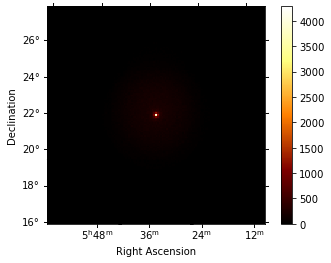

In [29]:
source = 'Crab'
dataset_standard = MapDataset.read(f'{source}/stacked.fits')
#models = Models.read(f'{source}/standard_model.yml')


from gammapy.modeling.models import GaussianSpatialModel, LogParabolaSpectralModel
spatial=GaussianSpatialModel(lon_0=83.6333313*u.deg, lat_0=22.01444435*u.deg, sigma=0.016*u.deg, reference='1 TeV', frame='icrs')
spectral=LogParabolaSpectralModel(amplitude='3.84e-11 cm-2 s-1 TeV-1', alpha=2.5, beta=0.105, reference='1TeV')
main_source= SkyModel(spatial_model=spatial, spectral_model=spectral, name='main source')

models = Models([main_source])

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters["tilt"].frozen = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)




Performing the standard fit. 

In [4]:
fit_standarad = Fit(store_trace=False)
result_standarad = fit_standarad.run([dataset_standard])
print(result_standarad)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (89.09546826, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (78.17119434, 22.01444435)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 27.44400828)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333313, 16.49820823)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoo

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 331
	total stat : -1251607.69

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 331
	total stat : -1251607.69




The first two energybins of the dataset are not fitted well ...

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


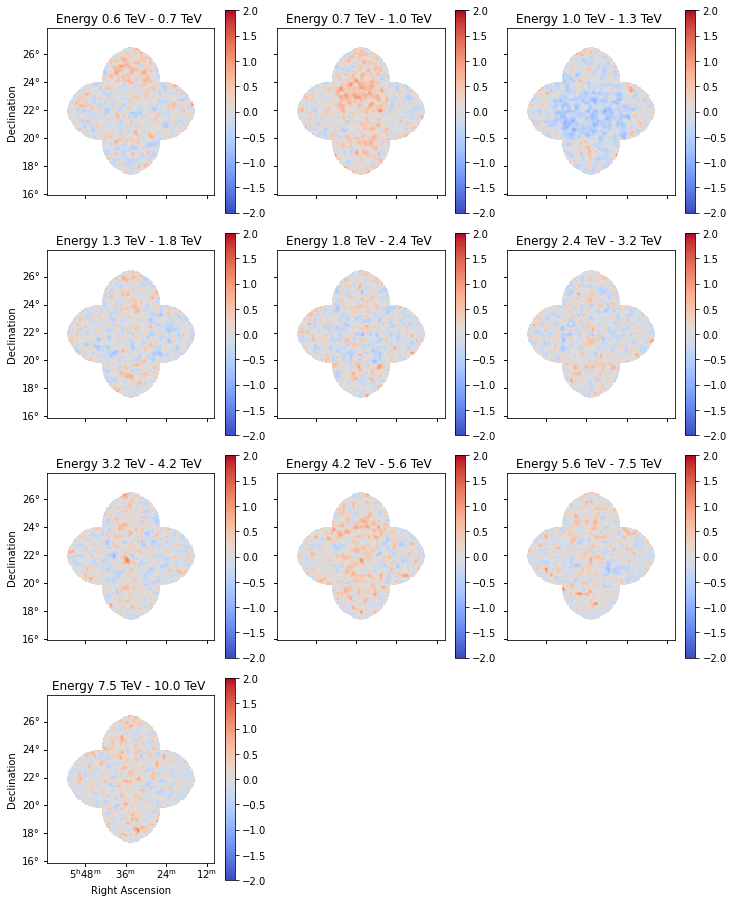

In [5]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
vmax = 2
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

## Nuisance Parameters

Here, two things are used to save computation time:
- The nuisance parameters are computed only within the first two energybins of the analysis (index 4 and 5) exemplary to save computation time. The indices are defined as `i_start` and `i_end`. This approximation is fine since the systematic uncertainites are known to be the largest at the smaller energies. 
- The nuisance parameter have a larger binsize than the counts cube. The downsampling factor `downsampling_factor` denotes that. This way, one nuisance parameter acts on multiple neighbor bins and the systematic uncertainty is averaged over them. The geometry of this downsampled nuisance parameter cube is saved in `dataset.geoms['geom_down']`.



In [59]:
angular_size_file = f'{source}/angular_size.txt'
angular_size = np.loadtxt(angular_size_file)
ndim_spatial = dataset_standard.geoms['geom'].data_shape[1]
print("Current Binning:", ndim_spatial)
possible_downsampling_factors = []
possible_binsizes = []
for i in range(1, ndim_spatial):
    if (ndim_spatial%i == 0):
        possible_downsampling_factors.append(i)
        possible_binsizes.append(binsize[0].value * i)


print(f"Possible downsampling factors: {possible_downsampling_factors}")
print(f"Resulting Binsize: {possible_binsizes}")

downsampling_factor_index = -1
while (possible_binsizes[downsampling_factor_index] > angular_size):
    downsampling_factor_index -=1
downsampling_factor =    possible_downsampling_factors[downsampling_factor_index]
print()
print(f"Chosen Downsampling Factor: \n {downsampling_factor}.")
print(f"This will result in a Binsize of the Nuisance Parameters of \n {possible_binsizes[downsampling_factor_index]} deg.")
print(f"Which is smaller than the observed angular size of the systematics of \n {angular_size} deg.")




Current Binning: 150
Possible downsampling factors: [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75]
Resulting Binsize: [0.08, 0.16, 0.24, 0.4, 0.48, 0.8, 1.2, 2.0, 2.4, 4.0, 6.0]

Chosen Downsampling Factor: 
 10.
This will result in a Binsize of the Nuisance Parameters of 
 0.8 deg.
Which is smaller than the observed angular size of the systematics of 
 1.0 deg.


In [6]:
i_start, i_end = 4, 6

The `nuisance_mask` describes where in the dataset the nuisance parameters are evaulated. It has the same geometry as `dataset.geoms['geom_down']`. 

In [7]:
nuisance_mask = (
    dataset_standard.geoms["geom"]
    .energy_mask(
        energy_min=dataset_standard.geoms["geom"].axes[0].edges[i_start],
        energy_max=dataset_standard.geoms["geom"].axes[0].edges[i_end],
    )
    .downsample(downsampling_factor)
)

The total amount of nuisance parameters in the dataset can now be computed (defined as `ndim_3D_nui`). The number of spatial and spectral dimensions of the nuisance parameter cube is defined as `ndim_spatial_nui` and `ndim_spectral_nui` since it is needed for the computation of the correlation matrix. Note that here the FoV is expected to be squared. 
The nuisance parameters are defined with their initial value set to `0`.

In [8]:
ndim_3D_nui = sum(nuisance_mask.data.flatten())
ndim_spatial_nui_1D = (
    dataset_standard.geoms["geom"]
    .downsample(downsampling_factor)
    .data_shape[1]
)
ndim_spatial_nui = ndim_spatial_nui_1D ** 2
ndim_spectral_nui = int(i_end - i_start)

print(f"Number of nuisance parameters: {ndim_3D_nui}")
print(
    "at energy: {:.2} : {:.2}".format(
        dataset_standard.geoms["geom"].axes[0].edges[i_start],
        dataset_standard.geoms["geom"].axes[0].edges[i_end],
    )
)

Nuisance_parameters = Parameters(
    [
        Parameter(name="db" + str(i), value=0, frozen=False)
        for i in range(ndim_3D_nui)
    ]
)

Number of nuisance parameters: 450
at energy: 0.32 TeV : 0.56 TeV


## Correlation of Nuisance Parameters

The Gaussian correlation matrix is the kronecker product of the spatial $K_{ij}$ and the spectral correlation matrix $K_{e}$: \
$ K_{ije} = K_{e} \cdot K_{ij} $

The spatial correlation matrix is defined as follows:

$K_{ij} = \exp \left( \frac{ -  (r_i - r_j ) ^2} {2\cdot l_{corr}^2}    \right)$,\
where $l_{corr}$ describes the spatial correlation length. Note that the correlation amplitude in the spatial correlation matrix is set to $1$. This is due to the fact, that we assume in the first order a uniformly distributed systematic uncertainty over the FoV. The correaltion amplitude was evaluated over the summed up FoV for each of the energybins and is therefore used in the spectral correlation desciption only.

The spectral correaltion matrix is:

$K_{s} = \sigma_s $, \
where $\sigma_s$ is the correlation amplitude in the spectral bin $s$. Note that here the correlation is in fact not Gaussian and there is no correlation between the energy bins. The correaltion is intrinsically included in the way the spectral correlation amplitude is defined. 


Therefor for the Gaussian correlation matrix $K_{ije}$ of the nuisance parameter one needs two parameters:
- `l_corr`: the spatial correlation length in deg. For instance, a Fourier transformation of the residual map of the standard analysis can be used to estimate the correlation length. Generally, it is important to choose a correaltion length greater than the bin size of the counts cube to avoid fitting the nuisance parameters without any correlation which can lead to overfitting the data. 
- `sysamplitude`: list of correlation amplitudes for the different energybins. The strength of the systematics can be estimated of the spectral residual points when taking only the OFF regions of all runs into account. Here, these obtained values are divided by the amount of spatial bins they were computed for.   

In [9]:
l_corr = 0.8
sysamplitude = [11, 4 ,4,4]

The `sysamplitude` can also be expressed in terms of expected counts due to systematic uncertainties in one energy bin and in terms of percent of the background counts. 

In [10]:
bg = (
    dataset_standard.background.slice_by_idx(
        dict(energy=slice(i_start, i_end))
    )
    .data.sum(axis=2)
    .sum(axis=1)
)
print(bg)
print("Estimated systematic uncertainty: ")
print()
print("Ebin                 [Counts]          [% BG]")

for e in range(ndim_spectral_nui):
    e_start, e_end = (
        dataset_standard.geoms["geom"].axes[0].edges[i_start + e],
        dataset_standard.geoms["geom"].axes[0].edges[i_start + e + 1],
    )
    sys_counts = sysamplitude[e] * ndim_spatial_nui * np.sqrt(bg[e])
    sys_percent = sys_counts / bg[e]

    print(
        "{:.2} : {:.2} TeV           {:.3}               {:.3}  ".format(
            e_start.value, e_end.value, sys_counts, sys_percent * 100
        )
    )

[0. 0.]
Estimated systematic uncertainty: 

Ebin                 [Counts]          [% BG]
0.32 : 0.42 TeV           0.0               nan  
0.42 : 0.56 TeV           0.0               nan  


/tmp/ipykernel_469/1265328958.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sys_percent = sys_counts / bg[e]


The spatial correlation matrix is computed with two helper maps to compute the separation angle between two spatial bins. Afterwards, the systematic amplitude is set as the diagonal of the spectral correlation matrix and the kroneker product of the two is returned as the overall correlation matrix. 

In [11]:
sigma = sys_map.data[:,0,0] # = sys_er[ii]/ ndim_spatial_nui 
sigma = (sys_er / np.sqrt(bg))[sys_er>0]
sigma = sysamplitude /   ndim_spatial_nui


l_corr = 0.001

geom_down = nuisance_mask.geom
helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
helper_map2 = helper_map.copy()


def compute_K_matrix(l_deg):
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sigma[e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

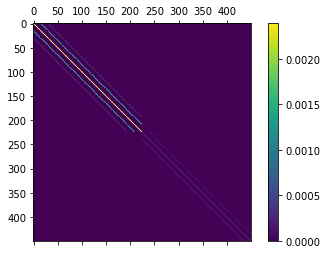

In [12]:
correlation_matrix = compute_K_matrix(l_corr)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix)  # interpolation='nearest')
fig.colorbar(cax);

# Initiate the MapDatasetNuisance

The MapDatasetNuisance class takes in addition to the MapDataset class:
- `inv_corr_matrix`: The inverse of the correlation matrix 
- ` N_parameters`: The nuisance parameters
- `nuisance_mask`: Mask to help evaluating the nuisance parameters in the background prediction

In [13]:
dataset_N = MapDatasetNuisance(
    background=dataset_standard.background,
    exposure=dataset_standard.exposure,
    psf=dataset_standard.psf,
    edisp=dataset_standard.edisp,
    mask_fit=dataset_standard.mask_fit,
    mask_safe=dataset_standard.mask_safe,
    counts=dataset_standard.counts,
    inv_corr_matrix=np.linalg.inv(correlation_matrix),
    N_parameters=Nuisance_parameters,
    nuisance_mask=nuisance_mask,
)

bkg_model = FoVBackgroundModel(dataset_name=dataset_N.name)
bkg_model.parameters["tilt"].frozen = False
models_NGC253.append(bkg_model)
dataset_N.models = models_NGC253
print(dataset_N)

NameError: name 'models_NGC253' is not defined

## Running the Fit

In [ ]:
fit_N = Fit(store_trace=False)
result_N = fit_N.run([dataset_N])

The method `N_map()` is a map in the origial geometry with the nuisance parameters as the data. It is used in npred_background() and visualises the best fit nuisance parameters.

In [ ]:
vmax = np.max(np.abs(dataset_N.N_map().data))
dataset_N.N_map().slice_by_idx(dict(energy=slice(i_start, i_end))).plot_grid(
    add_cbar=1, vmax=vmax, vmin=-vmax
);

## Comparison to Standard Analysis

The spectral residual points show again how especially the first two energybins are not fitted well

In [ ]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

After including the nuisance parameters the model description is much better in the first two energy bins. This indicates that the method worked and has improved out analysis.

In [ ]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(4, 6)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(res_standard.data))
res_N.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

In [ ]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

Her a comparison of the distribution of the significance maps in the first two energy bins is shown. With the nuisance parameters the mean of the distribution $\mu$ got closer to zero and the standard deviation $\sigma$ is closer to the expected $1$.

In [ ]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)

_, bins, _ = plt.hist(
    res_standard,
    bins=50,
    alpha=0.4,
    label="Standard: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_standard), np.std(res_standard)
    ),
)
plt.hist(
    res_N,
    bins=bins,
    alpha=0.4,
    label="Nuisance: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_N), np.std(res_N)
    ),
)
plt.yscale("log")
plt.legend()
plt.xlabel("Significance")
plt.ylabel("Amount");

## Comparsion of the erros of the best fit model parameters

The model errors of the Nuisance dataset have for now to be set by hand. 

In [ ]:
import my_dataset_core_19, my_fit_19
parameters  = Parameters.from_stack([dataset_N.N_parameters,dataset_N.models.parameters])
kwargs = fit_N.covariance_opts.copy()
kwargs["minuit"] = fit_N.minuit
backend = kwargs.pop("backend", fit_N.backend)
compute = my_fit_19.registry.get("covariance", backend)

with parameters.restore_status():

    factor_matrix, info = compute(
        parameters=parameters, function=dataset_N.stat_sum, **kwargs
    )


covariance = Covariance.from_factor_matrix(
                parameters=parameters, matrix=factor_matrix
            )
for par in dataset_N.models.parameters:
    pars = Parameters([par])
    variance = covariance.get_subcovariance(pars)
    par.error = np.sqrt(variance)

In [ ]:
print(" with nuisance")
print("(without nuisance)")


for p_N, p_stand in zip(dataset_N.models.parameters,dataset_standard.models.parameters ):
    print()
    print('='*50)
    print(p_N.name, p_stand.name)
    print('-'*50)
    print(' {:.3} pm {:.3}'.format(p_N.value, p_N.error) )    
    print('({:.3} pm {:.3})'.format(p_stand.value, p_stand.error) )


